Loaded CSV: C:\Users\abhin\Downloads\exchange_rate (2).csv
Initial shape: (7588, 2)


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


Columns detected: ['date', 'Ex_rate']
Using date column: date
Using series column: Ex_rate
Found 4590 rows with invalid dates — these rows will be dropped.

Series head after parsing:


date
1990-01-01    0.7855
1990-01-02    0.7500
1990-01-03    0.7471
1990-01-04    0.7587
1990-01-05    0.7852
Name: Ex_rate, dtype: float64

Time span: 1990-01-01 00:00:00 to 2010-12-09 00:00:00
Frequency could not be inferred. Proceeding without forcing freq.

Missing before interpolation: 0
Missing after imputation: 0


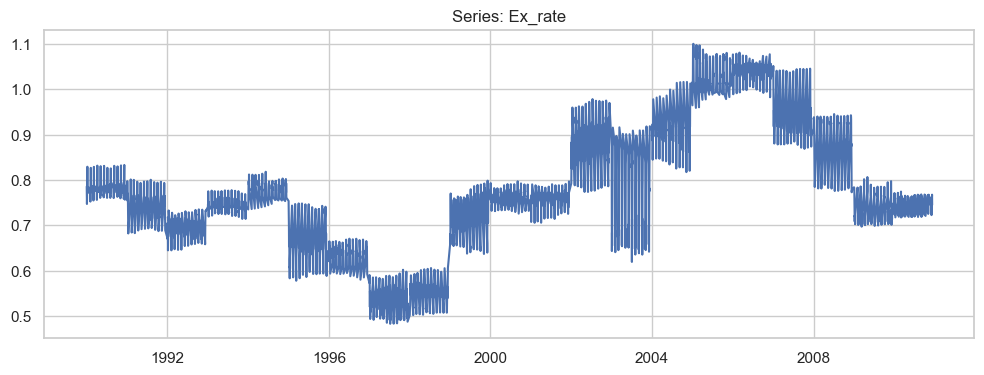

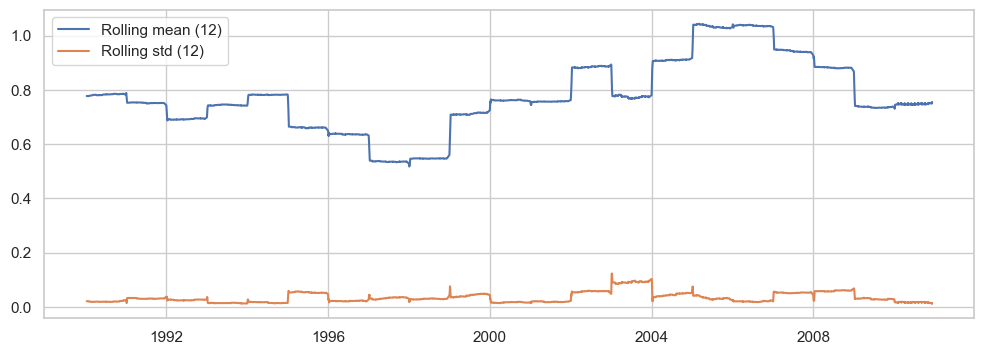


ADF Test: Ex_rate
ADF Statistic: -1.5399, p-value: 0.5137
Critical values:
 1%: -3.4326
 5%: -2.8625
 10%: -2.5673


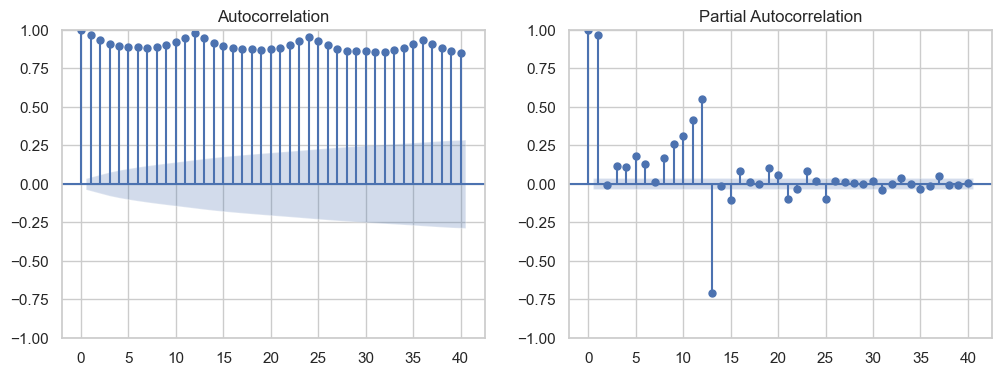


Using test_periods = 24


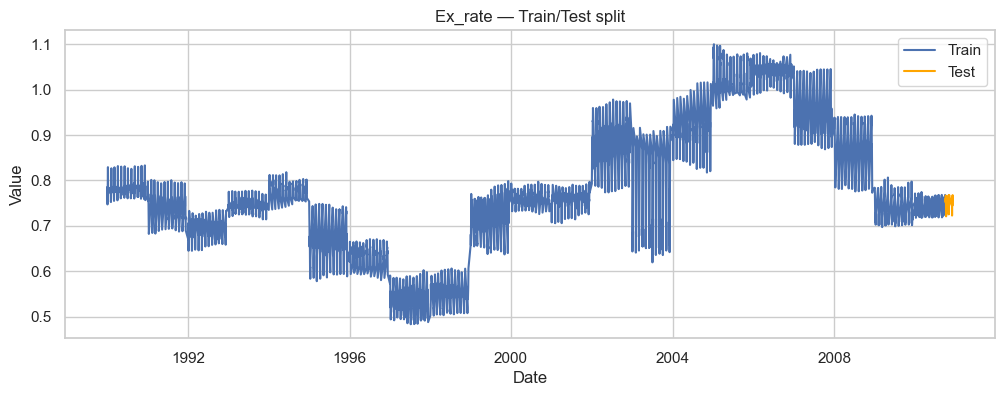

pmdarima not available: using small AIC grid search.
Selected order by AIC search: (3, 1, 3)

Fitting SARIMAX order: (3, 1, 3)
                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 2974
Model:               SARIMAX(3, 1, 3)   Log Likelihood                6033.747
Date:                Mon, 17 Nov 2025   AIC                         -12053.493
Time:                        20:19:40   BIC                         -12011.521
Sample:                             0   HQIC                        -12038.388
                               - 2974                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3609      0.020     17.710      0.000       0.321       0.401
ar.L

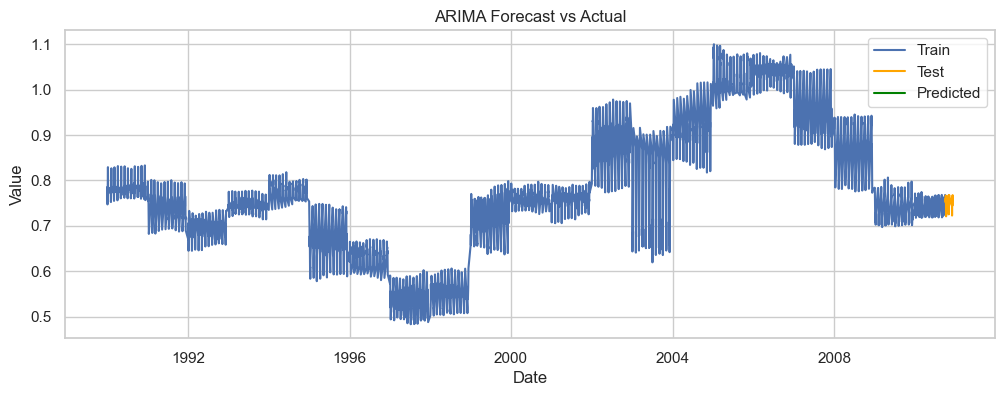


Seasonal periods guess: None


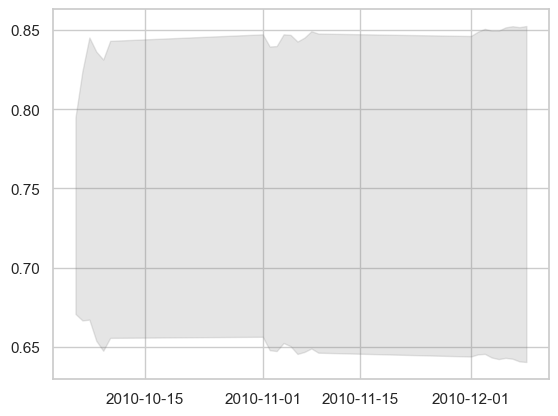

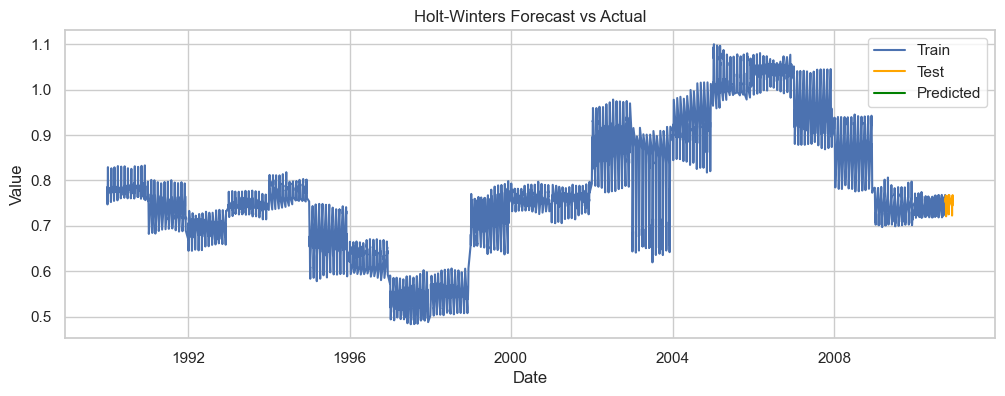


Eval frame shape and NaNs per column:
(24, 3)
actual     0
arima     24
hw        24
dtype: int64
Dropped 24 rows with NaNs. Using 0 rows for evaluation.
No valid rows left after dropping NaNs. Metrics cannot be computed.

Saved evaluation & forecasts to: C:\Users\abhin\ts_forecast_results_clean.csv

Done. If you want me to run seasonal SARIMA (SARIMAX with seasonal_order) or tune hyperparameters, say 'Run seasonal SARIMA' or 'Tune models'.


In [3]:
# ===========================
# Robust Time Series Forecasting: ARIMA & Holt-Winter
# ===========================
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")

# ---------- helper metrics / functions ----------
def safe_mae(a,b): return mean_absolute_error(a,b)
def safe_rmse(a,b): return np.sqrt(mean_squared_error(a,b))
def safe_mape(a,b):
    a = np.asarray(a); b = np.asarray(b)
    mask = a != 0
    return np.mean(np.abs((a[mask]-b[mask])/a[mask]))*100 if mask.sum()>0 else np.nan

def adf_test(series, title=''):
    print(f"\nADF Test: {title}")
    res = adfuller(series.dropna())
    print(f"ADF Statistic: {res[0]:.4f}, p-value: {res[1]:.4f}")
    print("Critical values:")
    for k,v in res[4].items():
        print(f" {k}: {v:.4f}")
    return res

def train_test_split_ts(series, test_periods):
    train = series.iloc[:-test_periods]
    test  = series.iloc[-test_periods:]
    return train, test

def plot_series(train, test=None, pred=None, title="Time Series", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(12,4))
    plt.plot(train.index, train.values, label='Train')
    if test is not None:
        plt.plot(test.index, test.values, label='Test', color='orange')
    if pred is not None:
        plt.plot(pred.index, pred.values, label='Predicted', color='green')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(); plt.show()

# ---------- USER PATH (change only if needed) ----------
DATA_PATH = r"C:\Users\abhin\Downloads\exchange_rate (2).csv"
FALLBACK = r"/mnt/data/exchange_rate (2).csv"

# ---------- LOAD DATA ----------
if os.path.exists(DATA_PATH):
    path = DATA_PATH
elif os.path.exists(FALLBACK):
    path = FALLBACK
else:
    raise FileNotFoundError(f"File not found. Update DATA_PATH. Tried:\n{DATA_PATH}\n{FALLBACK}")

# read CSV (Excel fallback)
try:
    df = pd.read_csv(path)
    print("Loaded CSV:", path)
except Exception:
    df = pd.read_excel(path)
    print("Loaded Excel:", path)

print("Initial shape:", df.shape)
display(df.head())

# ---------- auto-detect date & series column ----------
cols = df.columns.tolist()
print("Columns detected:", cols)
date_col = cols[0]
if len(cols) >= 2:
    series_col = cols[1]
else:
    raise ValueError("Dataset must have at least two columns: date and one series column.")

print("Using date column:", date_col)
print("Using series column:", series_col)

# ---------- parse date, drop bad-date rows, set index ----------
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
bad_dates = df[date_col].isna().sum()
if bad_dates > 0:
    print(f"Found {bad_dates} rows with invalid dates — these rows will be dropped.")
    df = df[~df[date_col].isna()].copy()

df = df.set_index(date_col).sort_index()

# ---------- prepare numeric series ----------
series = pd.to_numeric(df[series_col], errors='coerce')

print("\nSeries head after parsing:")
display(series.head())
print("Time span:", series.index.min(), "to", series.index.max())

# ---------- infer frequency (optional) ----------
inferred = pd.infer_freq(series.index)
if inferred is None:
    print("Frequency could not be inferred. Proceeding without forcing freq.")
else:
    print("Inferred frequency:", inferred)
    try:
        series = series.asfreq(inferred)
    except Exception:
        pass

# ---------- drop index-NaN rows (shouldn't be any) ----------
if series.index.hasnans:
    series = series[~series.index.isna()]

# ---------- missing-values handling (safe) ----------
print("\nMissing before interpolation:", series.isnull().sum())
# linear interpolation on values only (index has no NaT now), then ffill/bfill
series_imputed = series.copy().interpolate(method='linear').ffill().bfill()
print("Missing after imputation:", series_imputed.isnull().sum())

# ---------- basic plots & stationarity ----------
plt.figure(figsize=(12,4)); plt.plot(series_imputed); plt.title(f"Series: {series_col}"); plt.show()
plt.figure(figsize=(12,4)); plt.plot(series_imputed.rolling(window=12).mean(), label='Rolling mean (12)')
plt.plot(series_imputed.rolling(window=12).std(), label='Rolling std (12)'); plt.legend(); plt.show()

adf_res = adf_test(series_imputed, title=series_col)

# ACF / PACF (visual)
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(series_imputed.dropna(), lags=40, ax=ax[0])
plot_pacf(series_imputed.dropna(), lags=40, ax=ax[1])
plt.show()

# ---------- train-test split ----------
test_periods = 24
if test_periods >= len(series_imputed):
    test_periods = max(1, int(len(series_imputed) * 0.2))
print("\nUsing test_periods =", test_periods)
train, test = train_test_split_ts(series_imputed, test_periods)
plot_series(train, test, title=f"{series_col} — Train/Test split")

# ---------- choose ARIMA order ----------
use_auto = False
try:
    import pmdarima as pm
    use_auto = True
    print("pmdarima available: auto_arima will be used.")
except Exception:
    print("pmdarima not available: using small AIC grid search.")

if use_auto:
    try:
        auto = pm.auto_arima(train.dropna(), seasonal=False, stepwise=True, suppress_warnings=True,
                             error_action='ignore', max_p=5, max_q=5, max_d=2)
        p,d,q = auto.order
        print("auto_arima suggested order:", (p,d,q))
    except Exception:
        print("auto_arima failed — falling back to AIC grid.")
        use_auto = False

if not use_auto:
    # d guess from ADF p-value
    d_guess = 0 if adf_res[1] < 0.05 else 1
    best_aic = np.inf; best_order = (0,0,0)
    for p_try in range(0,4):
        for q_try in range(0,4):
            try:
                mod = SARIMAX(train.dropna(), order=(p_try,d_guess,q_try),
                              enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p_try,d_guess,q_try)
            except Exception:
                continue
    p,d,q = best_order
    print("Selected order by AIC search:", (p,d,q))

# ---------- Fit ARIMA (SARIMAX) safely ----------
print("\nFitting SARIMAX order:", (p,d,q))
arima_success = True
try:
    model_arima = SARIMAX(train.dropna(), order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
    res_arima = model_arima.fit(disp=False)
    print(res_arima.summary())
except Exception as e:
    print("ARIMA fit failed:", e)
    arima_success = False

# ---------- ARIMA forecast (aligned to test.index) ----------
if arima_success:
    try:
        n_forecast = len(test)
        arima_forecast = res_arima.get_forecast(steps=n_forecast)
        arima_mean = pd.Series(arima_forecast.predicted_mean, index=test.index)  # align index
        arima_ci = arima_forecast.conf_int()
        # ensure ci has same index
        arima_ci.index = test.index
    except Exception as e:
        print("ARIMA forecasting failed:", e)
        arima_mean = pd.Series([np.nan]*len(test), index=test.index)
        arima_ci = pd.DataFrame(index=test.index, data=np.nan, columns=[0,1])
else:
    arima_mean = pd.Series([np.nan]*len(test), index=test.index)
    arima_ci = pd.DataFrame(index=test.index, data=np.nan, columns=[0,1])

plot_series(train, test, arima_mean, title="ARIMA Forecast vs Actual")
if arima_ci is not None and not arima_ci.isnull().all().all():
    plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='gray', alpha=0.2)

# ---------- Holt-Winters (H-W) fit & forecast (safe) ----------
hw_success = True
seasonal_periods = None
if inferred and str(inferred).lower().startswith('m'):
    seasonal_periods = 12
elif inferred and str(inferred).lower().startswith('d'):
    seasonal_periods = 7

print("\nSeasonal periods guess:", seasonal_periods)
try:
    if seasonal_periods and len(train.dropna()) > 2*seasonal_periods:
        hw_model = ExponentialSmoothing(train.dropna(), trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    else:
        hw_model = ExponentialSmoothing(train.dropna(), trend='add', seasonal=None)
    res_hw = hw_model.fit(optimized=True)
    hw_pred = pd.Series(res_hw.forecast(len(test)), index=test.index)
except Exception as e:
    print("Holt-Winters failed:", e)
    hw_success = False
    hw_pred = pd.Series([np.nan]*len(test), index=test.index)

plot_series(train, test, hw_pred, title="Holt-Winters Forecast vs Actual")

# ---------- Safe evaluation: align indices and drop NaNs ----------
eval_df = pd.DataFrame({
    "actual": test,
    "arima": arima_mean,
    "hw": hw_pred
})
print("\nEval frame shape and NaNs per column:")
print(eval_df.shape); print(eval_df.isnull().sum())

# drop rows with any NaN before metrics
n_before = len(eval_df)
eval_clean = eval_df.dropna()
n_after = len(eval_clean)
print(f"Dropped {n_before-n_after} rows with NaNs. Using {n_after} rows for evaluation.")

if n_after == 0:
    print("No valid rows left after dropping NaNs. Metrics cannot be computed.")
else:
    print("\n--- Evaluation on clean test set ---")
    # ARIMA metrics (if available)
    if eval_clean['arima'].isnull().all():
        print("ARIMA predictions not available.")
    else:
        print("ARIMA MAE :", round(safe_mae(eval_clean['actual'], eval_clean['arima']),6))
        print("ARIMA RMSE:", round(safe_rmse(eval_clean['actual'], eval_clean['arima']),6))
        print("ARIMA MAPE:", round(safe_mape(eval_clean['actual'], eval_clean['arima']),4), "%")

    # Holt-Winters metrics (if available)
    if eval_clean['hw'].isnull().all():
        print("Holt-Winters predictions not available.")
    else:
        print("HW MAE :", round(safe_mae(eval_clean['actual'], eval_clean['hw']),6))
        print("HW RMSE:", round(safe_rmse(eval_clean['actual'], eval_clean['hw']),6))
        print("HW MAPE:", round(safe_mape(eval_clean['actual'], eval_clean['hw']),4), "%")

# ---------- Save results (cleaned) ----------
out_file = "ts_forecast_results_clean.csv"
eval_clean.to_csv(out_file, index=True)
print("\nSaved evaluation & forecasts to:", os.path.abspath(out_file))

# ---------- Final notes ----------
print("\nDone. If you want me to run seasonal SARIMA (SARIMAX with seasonal_order) or tune hyperparameters, say 'Run seasonal SARIMA' or 'Tune models'.")
